In [3]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2, RFECV

from data_handle import get_data_and_preprocess, cut_data, translate_to_ints, dic_attacks

%matplotlib inline
plt.rcParams['figure.facecolor'] = 'white'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dataset loading

In [4]:
normal_network, normal_energy = get_data_and_preprocess('normal', 'archer')
mirai_network, mirai_energy = get_data_and_preprocess('mirai', 'archer')

In [5]:
normal_network

,Time,Source,Destination,Protocol,Length,energy,target
0,0.000000,172.31.1.15,8.8.8.8,DNS,71,0.00,normal
1,0.020682,8.8.8.8,172.31.1.15,DNS,135,0.00,normal
2,5.002782,Tp-LinkT_81:9e:53,PcsCompu_73:1d:1d,ARP,60,0.14,normal
3,5.002810,PcsCompu_73:1d:1d,Tp-LinkT_81:9e:53,ARP,42,0.14,normal
4,5.053399,PcsCompu_73:1d:1d,Tp-LinkT_81:9e:53,ARP,42,0.14,normal
...,...,...,...,...,...,...,...
669,1783.318520,8.8.8.8,172.31.1.15,DNS,94,0.22,normal
670,1785.845176,172.31.1.15,8.8.8.8,DNS,68,0.22,normal
671,1785.858714,8.8.8.8,172.31.1.15,DNS,100,0.22,normal
672,1790.909397,PcsCompu_73:1d:1d,Tp-LinkT_81:9e:53,ARP,42,0.21,normal


In [7]:
# Get all datasets in the same time-frame
normal_network, normal_energy, mirai_network, mirai_energy = cut_data(normal_network, normal_energy, mirai_network, mirai_energy)

## Energy usage

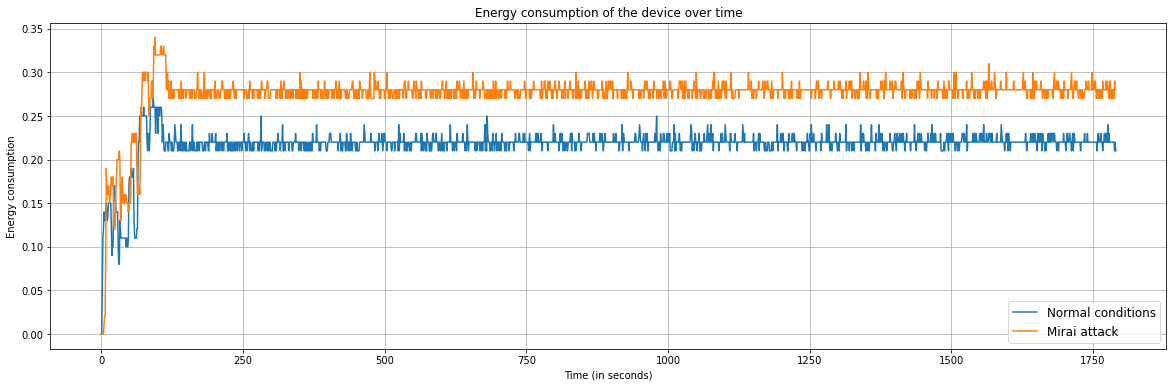

In [9]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 6)

ax.plot(normal_energy['time'], normal_energy['energy'], label='Normal conditions')
ax.plot(mirai_energy['time'], mirai_energy['energy'], label='Mirai attack')
ax.set_title('Energy consumption of the device over time')
ax.set_xlabel('Time (in seconds)')
ax.set_ylabel('Energy consumption')
ax.legend(loc=4, prop={'size': 12})
ax.grid()

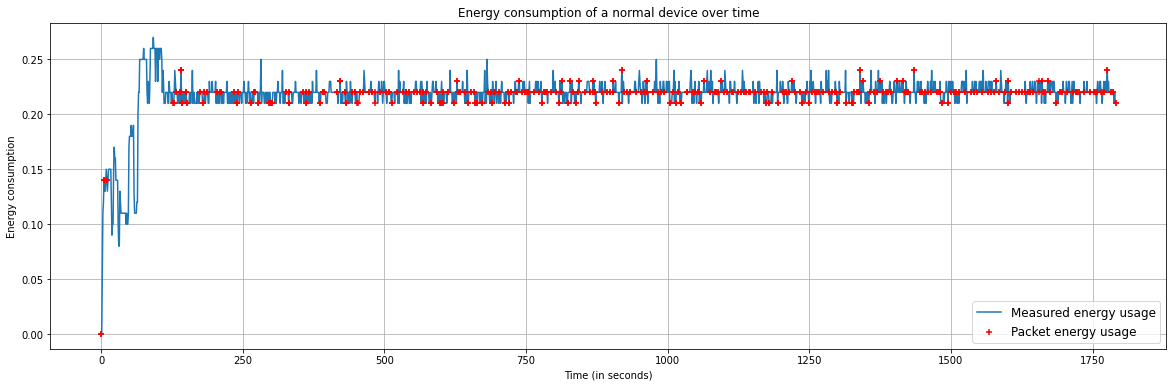

In [10]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 6)

max_time = min(normal_energy['time'].max(), mirai_energy['time'].max())

ax.plot(normal_energy['time'], normal_energy['energy'], label='Measured energy usage')
ax.scatter(normal_network['Time'], normal_network['energy'], label='Packet energy usage', c='r', marker='+', zorder=10)
ax.set_title('Energy consumption of a normal device over time')
ax.set_xlabel('Time (in seconds)')
ax.set_ylabel('Energy consumption')
ax.legend(loc=4, prop={'size': 12})
ax.grid()

## Protocol study

In [11]:
print("Count of the packets of each protocol")
df = pd.DataFrame()
df['Normal'] = normal_network.groupby('Protocol').count()['Length']
df['Mirai attack'] = mirai_network.groupby('Protocol').count()['Length']
df

Count of the packets of each protocol


,Normal,Mirai attack
Protocol,,
ARP,178,200
DHCP,12,12
DNS,430,464
NTP,4,4
TCP,32,437950
TLSv1.2,18,30


<AxesSubplot:title={'center':'Bar graph for each protocol in normal communications'}, ylabel='Count'>

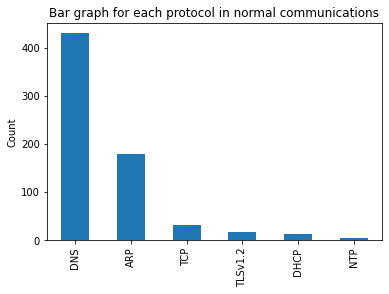

In [12]:
normal_network['Protocol'].value_counts().plot.bar(title="Bar graph for each protocol in normal communications", ylabel="Count")

## Getting data ready for the model

In [13]:
Final_merge_readable = normal_network.append(mirai_network)
Final_merge_readable = Final_merge_readable[Final_merge_readable.Protocol != 0]
Final_merge_readable

/tmp/ipykernel_31420/1347146614.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Final_merge_readable = normal_network.append(mirai_network)


,Time,Source,Destination,Protocol,Length,energy,target
0,0.000000,172.31.1.15,8.8.8.8,DNS,71,0.00,normal
1,0.020682,8.8.8.8,172.31.1.15,DNS,135,0.00,normal
2,5.002782,Tp-LinkT_81:9e:53,PcsCompu_73:1d:1d,ARP,60,0.14,normal
3,5.002810,PcsCompu_73:1d:1d,Tp-LinkT_81:9e:53,ARP,42,0.14,normal
4,5.053399,PcsCompu_73:1d:1d,Tp-LinkT_81:9e:53,ARP,42,0.14,normal
...,...,...,...,...,...,...,...
438657,1786.267402,172.31.0.17,172.31.1.15,TCP,74,0.28,mirai
438658,1786.267408,172.31.0.17,172.31.1.15,TCP,74,0.28,mirai
438659,1786.267413,172.31.0.17,172.31.1.15,TCP,74,0.28,mirai
438660,1786.267417,172.31.0.17,172.31.1.15,TCP,74,0.28,mirai


In [14]:
Final_merge = translate_to_ints(Final_merge_readable.copy())

In [15]:
Final_merge.to_csv('QRS_dataset/FinalSet.csv')

## Random Forest

In [16]:
# Target variable and train set
y = Final_merge[['target']]
X = Final_merge.drop(['target', ], axis = 1)

# Split test and train data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.6, random_state = 42)
print('Train size:', X_train.shape[0])
print('Test size: ', X_test.shape[0])

Train size: 175734
Test size:  263602


In [26]:
clf = RandomForestClassifier(5)
_=clf.fit(X_train, y_train['target'])

In [18]:
print("Original mirai packet share:", mirai_network.shape[0]/(normal_network.shape[0]+mirai_network.shape[0]))

print("Score:", clf.score(X_test, y_test))

y_pred = clf.predict(X_test)

dic_attacks_inv = {v:k for k,v in dic_attacks.items()}

unique, counts = np.unique(y_pred, return_counts=True)
unique = [dic_attacks_inv[u] for u in unique]
df = pd.DataFrame(index=unique)
df['predicted'] = counts
unique, counts = np.unique(y_test, return_counts=True)
df['actual'] = counts
df

Original mirai packet share: 0.9984658666715225
Score: 0.9999848256083034


,predicted,actual
normal,399,401
mirai,263203,263201


In [19]:
clf_cv_score = cross_val_score(clf, X, y['target'], cv=10, scoring='roc_auc')
clf_cv_score

array([0.9986265, 1.       , 1.       , 1.       , 1.       , 1.       ,
       1.       , 1.       , 1.       , 1.       ])

In [20]:
print("=================== Confusion Matrix ======================")
print(metrics.confusion_matrix(y_test, y_pred))
print('\n') 
print("=================== Classification Report =================")
print(metrics.classification_report(y_test, y_pred))
print('\n') 
print("=================== All AUC Scores =======================")
print(clf_cv_score)
print('\n') 
print("=================== Mean AUC Score =======================")
print("Mean AUC Score - Random Forest: ", clf_cv_score.mean())

=================== Confusion Matrix ======================
[[   398      3]
 [     1 263200]]


=================== Classification Report =================
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       401
           1       1.00      1.00      1.00    263201

    accuracy                           1.00    263602
   macro avg       1.00      1.00      1.00    263602
weighted avg       1.00      1.00      1.00    263602



=================== All AUC Scores =======================
[0.9986265 1.        1.        1.        1.        1.        1.
 1.        1.        1.       ]


=================== Mean AUC Score =======================
Mean AUC Score - Random Forest:  0.9998626498882961


In [21]:
# find best scored 5 features
select_feature = SelectKBest(chi2, k=5).fit(X_train, y_train)
print('Score list:', select_feature.scores_)
print('Feature list:', X_train.columns)

Score list: [8.20529416e+03 1.53758104e+03 8.04305991e+02 6.99464655e+02
 1.87438876e+03 3.53279697e+00]
Feature list: Index(['Time', 'Source', 'Destination', 'Protocol', 'Length', 'energy'], dtype='object')


In [22]:
# The "accuracy" scoring is proportional to the number of correct classifications
clf_rf_4 = RandomForestClassifier(5) 
rfecv = RFECV(estimator=clf_rf_4, step=1, cv=5,scoring='accuracy')   #5-fold cross-validation
rfecv = rfecv.fit(X_train, y_train['target'])

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X_train.columns[rfecv.support_])

Optimal number of features : 5
Best features : Index(['Time', 'Destination', 'Protocol', 'Length', 'energy'], dtype='object')


In [23]:
rfecv.grid_scores_

/home/alexis/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


array([[0.99997155, 0.99997155, 1.        , 1.        , 0.99997155],
       [0.99991464, 0.99997155, 1.        , 0.99985774, 0.99997155],
       [0.99991464, 0.99997155, 1.        , 1.        , 1.        ],
       [0.99988619, 0.99997155, 1.        , 1.        , 1.        ],
       [0.99997155, 0.99997155, 1.        , 1.        , 1.        ],
       [0.99997155, 1.        , 1.        , 1.        , 0.99997155]])

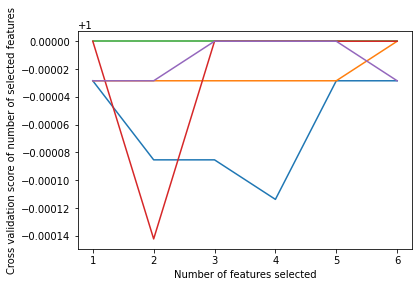

In [24]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

Feature ranking:
1. feature 5 (0.743009)
2. feature 4 (0.152272)
3. feature 0 (0.059785)
4. feature 1 (0.042239)
5. feature 2 (0.002696)
6. feature 3 (0.000000)


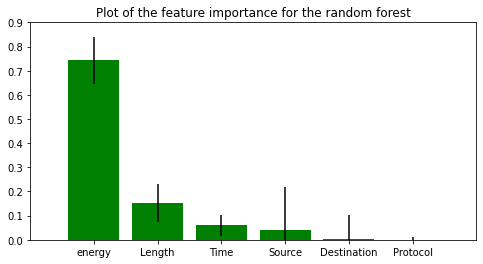

In [28]:
clf_rf_5 = RandomForestClassifier(5)
clr_rf_5 = clf_rf_5.fit(X_train,y_train['target'])
importances = clr_rf_5.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest

plt.figure(1, figsize=(8, 4))
#plt.title("Feature importances for the Random forest")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="g", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices],rotation=0)
plt.xlim([-1, X_train.shape[1]])
plt.ylim((0,.9))
plt.title('Plot of the feature importance for the random forest')
plt.show()
#plt.savefig('books_read.png')

## Federated

Check out the files `server.py` and `client.py`